In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from preprocess_data import DeepfakeDataset, IMAGE_TRANSFORM_TRAIN, IMAGE_TRANSFORM_VAL, get_images_paths
from visualizations import view_picture
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch

In [2]:
model_type_paths = ['imagenet_ai_0419_biggan', 'imagenet_ai_0508_adm', 'imagenet_glide']

#path to data should be changed according to yours
images_paths_train, images_paths_val, labels_train, labels_val  = get_images_paths('/Users/iaroslav/Downloads')

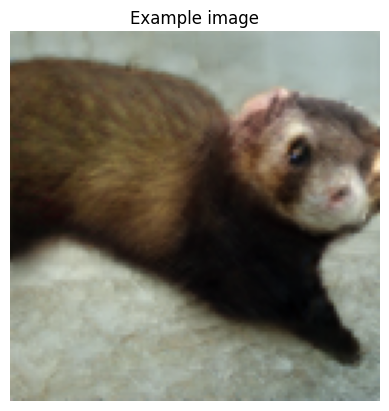

In [5]:
view_picture(images_paths_val[67])

In [ ]:
dataset_train = DeepfakeDataset(images_paths_train, labels_train, transform=IMAGE_TRANSFORM_TRAIN)
dataset_test = DeepfakeDataset(images_paths_val, labels_val, transform=IMAGE_TRANSFORM_VAL)

train_loader = DataLoader(
    dataset_train ,
    batch_size=32,
    shuffle=True,
    num_workers=0) #set 4 on windows/linux

val_loader = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle = False,
    num_workers=2) #set 2 on windows/linux

len(dataset_train), len(dataset_test)

(12000, 3000)

In [4]:
# loading trained with ImageNet(~12m pictures) model with CNN(resnet) architecture
resnet = models.resnet18(pretrained=True)

# last layer is replaced with linear layer with 2 outputs
resnet.fc = nn.Linear(resnet.fc.in_features, 2)

/Users/iaroslav/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/iaroslav/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
device_pc = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device_pc)
print("Device:", device_pc)

Device: cpu


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    resnet.train()
    train_loss = 0
    train_batches = 0

    for images, labels in train_loader:
        images = images.to(device_pc)
        labels = labels.to(device_pc)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss/train_batches
    print(f"Train loss: {avg_train_loss:.4f}")

    resnet.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device_pc)
            labels = labels.to(device_pc)

            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
    

    avg_val_loss = val_loss/len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)
    scheduler.step()

    print(f"Val loss: {avg_val_loss:.4f}")
    print(f"Val acc: {accuracy:.4f}")

Epoch 1


KeyboardInterrupt: 